In [2]:
#import Pakete
#plotten:
import matplotlib as mlp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#rechnen:
import numpy as np
from statistics import mean

#fitten:
import scipy 
from scipy.optimize import curve_fit
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import argrelextrema #für maxima/minima auch lokal
import scipy.special as sp
#import scipy.constants as sp # für grundlegende Konstanten --> https://docs.scipy.org/doc/scipy/reference/constants.html
#--> eher selbst machen 

#paket für automatische invertierung Funktion --> sehr nützlich
#from pynverse import inversefunc

#dateneinlesen einfach
import pylab as py 

import IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

import os  

In [3]:
def Stress_aus_curvature(k, k_0, d_sub, d_film, M_sub):
    #aus Quelle: A. Krost_2003_GaN-based epitaxy on silicon; stress measurements
    return ((k-k_0) *(d_sub**2) *M_sub ) / (6 * d_film)

def Stress_aus_curvature_ohne_relaxation(k, d_sub, d_film, M_sub):
    #aus Quelle: A. Krost_2003_GaN-based epitaxy on silicon; stress measurements
    return (k *(d_sub**2) *M_sub ) / (6 * d_film)

def Strain_aus_curvature(k, k_0, d_sub, d_film, M_sub, M_film):
    #aus Quelle: A. Krost_2003_GaN-based epitaxy on silicon; stress measurements
    return ((k-k_0) *(d_sub**2) *M_sub ) / (6 * d_film * M_film)

def Lin(x,a,b):
    return a*x + b

# Datenladen

In [4]:
#Path zu daten definieren
path = "./Daten//"  

In [5]:
x_in_s,y_curvature_in_km,y_reflektomitrie=py.loadtxt(path+ "Curvature Data MD-GaN-Ge_Refektometrie.txt", unpack=True, skiprows=2)
print(x_in_s)
print(y_curvature_in_km)
x_in_min=x_in_s/60
print(x_in_min)
print(len(y_reflektomitrie))

[5.99500000e-01 2.99850100e+00 5.39150000e+00 ... 4.93487205e+04
 4.93511165e+04 4.93535125e+04]
[-227.547511    7.934096    9.280352 ... -475.713335 -475.713335
 -475.713335]
[9.99166667e-03 4.99750167e-02 8.98583333e-02 ... 8.22478675e+02
 8.22518608e+02 8.22558542e+02]
20601


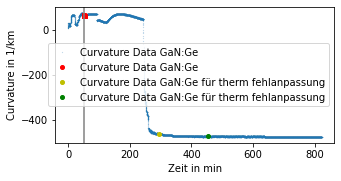

295.44739599999997 -463.665745
455.21515833333336 -475.385736


In [6]:
fig = plt.figure(figsize=(5,2.5))
plt.plot(x_in_min, y_curvature_in_km, 'o',markersize=0.1, label="Curvature Data GaN:Ge")#, markevery=10
plt.plot(x_in_min[1250:1350], y_curvature_in_km[1250:1350], 'o', color='r',markersize=4, label="Curvature Data GaN:Ge")#, markevery=10
plt.plot(x_in_min[7400], y_curvature_in_km[7400], 'o', color='y',markersize=4, label="Curvature Data GaN:Ge für therm fehlanpassung")#, markevery=10
plt.plot(x_in_min[11400], y_curvature_in_km[11400], 'o', color='g',markersize=4, label="Curvature Data GaN:Ge für therm fehlanpassung")#, markevery=10

#plt.axvline(x=245, ymin=0, ymax=1, color='gray')
#plt.axvline(x=124, ymin=0, ymax=1, color='gray')
#plt.axvline(x=90, ymin=0, ymax=1, color='gray')#x=58
plt.axvline(x=52.43, ymin=0, ymax=1, color='gray')
#plt.text(x=95,y=3,s='GaN')
#plt.text(x=170,y=3,s='GaN:Ge')
#plt.ylim (0, 100)
#plt.xlim (0, 250)
plt.ylabel('Curvature in 1/km')
plt.xlabel('Zeit in min')
plt.legend()
#plt.savefig('Bilder/Curvature_Daten_Probenwachstum', bbox_inches = "tight")
plt.show()

print(x_in_min[7400],y_curvature_in_km[7400])
print(x_in_min[11400],y_curvature_in_km[11400])

# Datenbearbeiten und Anpassen

## Nullpunkte neu setzen

In [7]:
print("setze Verspannung bei rund 52 min, 43 s auf null = Verspannungsfrei \nab da GaN wachstum")

setze Verspannung bei rund 52 min, 43 s auf null = Verspannungsfrei 
ab da GaN wachstum


In [8]:
#verspannung an minimum des markierten bereiches
neue_Curvature_Null = min(y_curvature_in_km[1250:1350])
print("Minimum um 50 min --> Wachstumsbeginn GaN; hat Verspannung: ", neue_Curvature_Null)

print("Position in Daten:", np.where(y_curvature_in_km == min(y_curvature_in_km[1250:1350]))[0][0])

Zeitpunkt_GaN_Wachstumsbeginn = x_in_min[np.where(y_curvature_in_km == min(y_curvature_in_km[1250:1350]))[0][0]]
print("Zeitpunkt in minuten: ",Zeitpunkt_GaN_Wachstumsbeginn)

Minimum um 50 min --> Wachstumsbeginn GaN; hat Verspannung:  60.147881
Position in Daten: 1313
Zeitpunkt in minuten:  52.43876258333333


In [9]:
#print(len(y_curvature_in_km))

In [10]:
#neue null für verspannung und GaN wachstumsbeginn einbauen
for i in range(len(y_curvature_in_km)):
    y_curvature_in_km[i]= y_curvature_in_km[i] - neue_Curvature_Null
    x_in_min[i]=x_in_min[i]- Zeitpunkt_GaN_Wachstumsbeginn

In [11]:
#print(y_curvature_in_km)

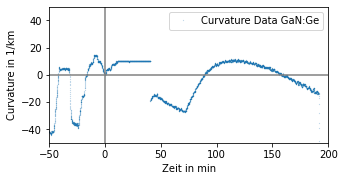

Nullpunkte angepasst


In [12]:
fig = plt.figure(figsize=(5,2.5))
plt.plot(x_in_min, y_curvature_in_km, 'o',markersize=0.1, label="Curvature Data GaN:Ge")#, markevery=10
#plt.plot(x_in_min[1250:1350], y_curvature_in_km[1250:1350], 'o', color='r',markersize=4, label="Curvature Data GaN:Ge")#, markevery=10

#plt.axvline(x=245, ymin=0, ymax=1, color='gray')
#plt.axvline(x=124, ymin=0, ymax=1, color='gray')
#plt.axvline(x=90, ymin=0, ymax=1, color='gray')#x=58
plt.axvline(x=0, ymin=0, ymax=1, color='gray')
plt.axhline(y=0, xmin=0, xmax=1, color='gray')

#plt.text(x=95,y=3,s='GaN')
#plt.text(x=170,y=3,s='GaN:Ge')
plt.ylim (-50, 50)
plt.xlim (-50, 200)
plt.ylabel('Curvature in 1/km')
plt.xlabel('Zeit in min')
plt.legend()
plt.savefig('Bilder_V2/Curvature_Daten_Probenwachstum_neue_Nullpunkte', bbox_inches = "tight")
plt.show()

print("Nullpunkte angepasst")

## Lineares anfitten 

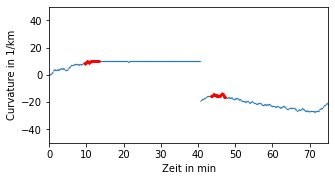

In [13]:
fig = plt.figure(figsize=(5,2.5))
plt.plot(x_in_min, y_curvature_in_km, 'o',markersize=0.1, label="Curvature Data GaN:Ge")#, markevery=10
plt.plot(x_in_min[1550:1650], y_curvature_in_km[1550:1650], 'o', color='r',markersize=1, label="Curvature Data GaN:Ge")#, markevery=10
plt.plot(x_in_min[2400:2500], y_curvature_in_km[2400:2500], 'o', color='r',markersize=1, label="Curvature Data GaN:Ge")#, markevery=10

#plt.axvline(x=245, ymin=0, ymax=1, color='gray')
#plt.axvline(x=124, ymin=0, ymax=1, color='gray')
#plt.axvline(x=90, ymin=0, ymax=1, color='gray')#x=58
#plt.axvline(x=52.43, ymin=0, ymax=1, color='gray')
#plt.text(x=95,y=3,s='GaN')
#plt.text(x=170,y=3,s='GaN:Ge')
plt.ylim (-50, 50)
plt.xlim (0, 75)
plt.ylabel('Curvature in 1/km')
plt.xlabel('Zeit in min')
#plt.legend()
#plt.savefig('Bilder/Curvature_Daten_Probenwachstum', bbox_inches = "tight")
plt.show()

lineares approzimieren zwischen den markierten Bereichen wegen fehlender messdaten --> bereich hier nur mit gerade weitergeführt

In [14]:
init_vals = [-100, 1] #Fitparameter initialisieren (n0,k,l)
#Falls der Fit nicht konvergiert muessen die Startparameter geaendert werden
x=np.concatenate((x_in_min[1550:1650],x_in_min[2400:2500]), axis=0)
y=np.concatenate((y_curvature_in_km[1550:1650],y_curvature_in_km[2400:2500]), axis=0)
fitParams, fitCovariances = curve_fit(Lin, x, y ,p0=init_vals)
#curve_fit() uebergibt den gefundenen Parametersatz und die Kovarianzmatrix

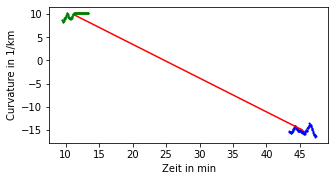

In [15]:
fig = plt.figure(figsize=(5,2.5))
#plt.plot(x_in_min, y_curvature_in_km, 'o',markersize=0.1, label="Curvature Data GaN:Ge")#, markevery=10
plt.plot(x_in_min[1550:1650], y_curvature_in_km[1550:1650], 'o', color='g',markersize=1, label="Curvature Data GaN:Ge")#, markevery=10
plt.plot(x_in_min[2400:2500], y_curvature_in_km[2400:2500], 'o', color='b',markersize=1, label="Curvature Data GaN:Ge")#, markevery=10
plt.plot(x_in_min[1600:2450], Lin(x_in_min[1600:2450],fitParams[0],fitParams[1]), color='r',markersize=0.1, label="Curvature Data GaN:Ge")#, markevery=10

#plt.axvline(x=245, ymin=0, ymax=1, color='gray')
#plt.axvline(x=124, ymin=0, ymax=1, color='gray')
#plt.axvline(x=90, ymin=0, ymax=1, color='gray')#x=58
#plt.axvline(x=52.43, ymin=0, ymax=1, color='gray')
#plt.text(x=95,y=3,s='GaN')
#plt.text(x=170,y=3,s='GaN:Ge')
#plt.ylim (-50, 50)
#plt.xlim (0, 200)
plt.ylabel('Curvature in 1/km')
plt.xlabel('Zeit in min')
#plt.legend()
#plt.savefig('Bilder/Curvature_Daten_Probenwachstum', bbox_inches = "tight")
plt.show()

neue gesammt werte bilden:

In [16]:
y=np.concatenate((y_curvature_in_km[0:1600],Lin(x_in_min[1600:2450],fitParams[0],fitParams[1])), axis=0)
y_curvature_in_km_neu = np.concatenate((y,y_curvature_in_km[2450:]), axis=0)

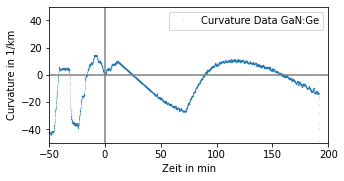

In [17]:
fig = plt.figure(figsize=(5,2.5))
plt.plot(x_in_min, y_curvature_in_km_neu, 'o',markersize=0.1, label="Curvature Data GaN:Ge")#, markevery=10

plt.axvline(x=0, ymin=0, ymax=1, color='gray')
plt.axhline(y=0, xmin=0, xmax=1, color='gray')

plt.ylim (-50, 50)
plt.xlim (-50, 200)
plt.ylabel('Curvature in 1/km')
plt.xlabel('Zeit in min')
plt.legend()
plt.savefig('Bilder_V2/Curvature_Daten_Probenwachstum_lineare_Datenkorrektur', bbox_inches = "tight")
plt.show()



# Reflectometrie daten machen

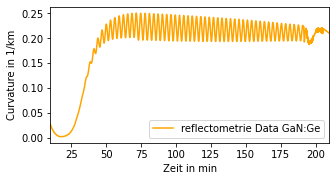

In [18]:
fig = plt.figure(figsize=(5,2.5))
plt.plot(x_in_min, y_reflektomitrie, color='orange', label="reflectometrie Data GaN:Ge")#,markersize=0.5
#plt.ylim (0, 100)
plt.xlim (10, 210)
plt.ylabel('Curvature in 1/km')
plt.xlabel('Zeit in min')
plt.legend()
plt.savefig('Bilder_V2/reflectometrie_Daten_Probenwachstum', bbox_inches = "tight")
plt.show()

In [19]:
#a möglickeit bestimmung ob Punkt Maxima ist über np --> vergleicht jeden Punkt mit nachbarn und gibt true wenn es ein max ist
a=np.r_[True, y_reflektomitrie[1:] > y_reflektomitrie[:-1]] & np.r_[y_reflektomitrie[:-1] > y_reflektomitrie[1:], True]
print(a)
print(len(a))

#b möglickeit bestimmung ob Punkt Maxima ist über np --> vergleicht jeden Punkt mit 2ten nachbarn und gibt true wenn es ein max ist
b=np.r_[True, y_reflektomitrie[2:] > y_reflektomitrie[:-2]] & np.r_[y_reflektomitrie[:-2] > y_reflektomitrie[2:], True]
#len(np.r_[True, y_reflektomitrie[1:] < y_reflektomitrie[:-1]] & np.r_[y_reflektomitrie[:-1] < y_reflektomitrie[1:], True])
print(b)
print(len(b))

#c möglickeit bestimmung ob Punkt Maxima ist über np --> vergleicht jeden Punkt mit 3ten nachbarn und gibt true wenn es ein max ist
c=np.r_[True, y_reflektomitrie[3:] > y_reflektomitrie[:-3]] & np.r_[y_reflektomitrie[:-3] > y_reflektomitrie[3:], True]
#len(np.r_[True, y_reflektomitrie[1:] < y_reflektomitrie[:-1]] & np.r_[y_reflektomitrie[:-1] < y_reflektomitrie[1:], True])
print(c)
print(len(c))

[ True False False ... False  True False]
20601
[ True False False ... False  True False]
20600
[ True False  True ... False  True False]
20599


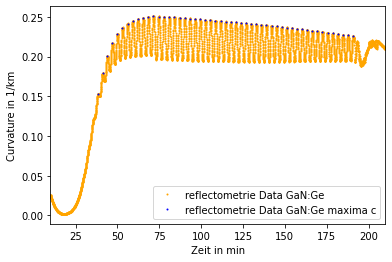

In [20]:
#Maxima von a, b und c:
x_test=[]
y_test=[]
for i in range(len(c)):
    if c[i] == True:
        x_test.append(x_in_min[i]) 
        y_test.append(y_reflektomitrie[i])

#x_test_2=[]
#y_test_2=[]
#for i in range(len(b)):
#    if b[i] == True:
#        x_test_2.append(x_in_min[i]) 
#        y_test_2.append(y_reflektomitrie[i])
        
#x_test_3=[]
#y_test_3=[]
#for i in range(len(a)):
#    if a[i] == True:
#        x_test_3.append(x_in_min[i]) 
#        y_test_3.append(y_reflektomitrie[i])
#print(x_test)
#print(y_test)

plt.plot(x_in_min, y_reflektomitrie, 'o', color='orange',markersize=1, label="reflectometrie Data GaN:Ge")
plt.plot(x_test[166:217], y_test[166:217], 'o', color='b',markersize=1, label="reflectometrie Data GaN:Ge maxima c")
#plt.plot(x_test_2, y_test_2, 'o', color='r',markersize=1, label="reflectometrie Data GaN:Ge maxima b")
#plt.plot(x_test_3, y_test_3, 'o', color='g',markersize=1, label="reflectometrie Data GaN:Ge maxima a")

#plt.ylim (0, 100)
plt.xlim (10, 210)
#plt.xlim (243.75, 245)
plt.ylabel('Curvature in 1/km')
plt.xlabel('Zeit in min')
plt.legend()
plt.show()



In [21]:
diffs=[]
for i in range(len(x_test[166:217])):
    if i > 0:
        diffs.append(x_test[166:217][i]-x_test[166:217][i-1])
mitteldiff=mean(diffs)
print(len(x_test[166:217])) #evt noch + 2 da eine osszillation am anfang sehr klein ersichtlich und eine am ende leicht schief
print(diffs)
print(mitteldiff) # d.h. im mittel eine Oszillation alle 3.04min ab startpunkt

#print("\nan Zeitpunkt:", x_test[166:217][0], "ist dann GaN dicke rund 0")
#print("bei wachtstumsrate von 132nm pro oszillation ist dann am endpunkt der 51 oszillation bei", x_test[166:217][50], 
#      "min, die dicke bei", 132*51,"nm bei den geplotteten maxima")
#print("mit den weiteren 2 ersichtlichen aber nicht geplotteten ergibt sich dann eine dicke der GaN schicht von", 132*53)

51
[2.674849999999992, 2.794466666666665, 2.994083333333336, 2.9941166666666703, 3.0340166666666732, 3.073999999999984, 3.074300000000008, 3.0741000000000014, 3.0742500000000064, 3.073783333333324, 3.0740333333333325, 3.193883333333332, 3.11399999999999, 3.1542833333333533, 3.1136833333333414, 3.0741333333333216, 3.074150000000003, 3.0742166666666435, 3.073916666666662, 3.0739166666666904, 3.0343499999999892, 3.073516666666677, 3.03391666666667, 3.0741999999999905, 3.0337000833333434, 3.073966666666678, 3.0341666666666356, 3.0445166666666807, 3.0335999999999785, 3.033816666666695, 3.033666666666676, 3.0338999999999885, 3.0335833333333255, 3.0734500000000082, 3.033466666666669, 3.0337333333333163, 3.0334166666666817, 3.0335333333333097, 3.0734666666666897, 3.0335833333333255, 3.033699999999982, 3.073483333333371, 3.033649999999966, 3.0337000000000103, 3.073666666666668, 3.0339333333333514, 3.0336499999999944, 3.0338166666666666, 3.0737166666666553, 3.0738000000000056]
3.0452970016666665

In [22]:
nm_per_min=132/mitteldiff
print("Material pro Minute:", nm_per_min, "nm")

Material pro Minute: 43.34552588064726 nm


In [23]:
#print("Umrechnen Zeitachse in Dicken:")
x_in_nm=[]
for i in range(len(x_in_min)):
    x_in_nm.append(x_in_min[i]*nm_per_min)

x_in_mikrom=[]
for j in range(len(x_in_nm)):
    x_in_mikrom.append(x_in_nm[j]/1000)

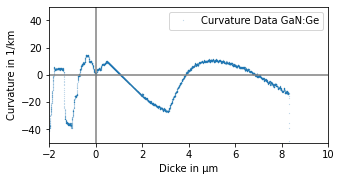

In [24]:
fig = plt.figure(figsize=(5,2.5))
plt.plot(x_in_mikrom, y_curvature_in_km_neu, 'o',markersize=0.1, label="Curvature Data GaN:Ge")#, markevery=10

plt.axvline(x=0, ymin=0, ymax=1, color='gray')
plt.axhline(y=0, xmin=0, xmax=1, color='gray')
plt.ylim (-50, 50)
plt.xlim (-2, 10)
plt.ylabel('Curvature in 1/km')
plt.xlabel('Dicke in \u03bcm')
plt.legend()
#plt.savefig('Bilder_V2/Curvature_Daten_Probenwachstum_nach_Dicke_GaN', bbox_inches = "tight")
plt.show()



# Stress berechnen

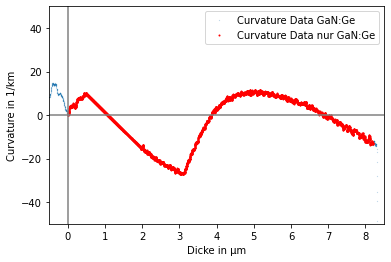

In [25]:
min_dicke=0
max_dicke=8.2


x_in_muem_nach_GaN_start_wichtiger_Bereich = []
y_curvature_in_km_wichtiger_Bereich = []
for i in range(len(x_in_mikrom)):
    if x_in_mikrom[i] >= min_dicke and x_in_mikrom[i] <= max_dicke:
        #wegen neuer null bei Air interface wurde pereiche invertiert: if x_in_muem_nach_GaN_start[i] <= -0.15 and x_in_muem_nach_GaN_start[i] >= -6.75    :(wenn 0 an GaN wachstumsbeginn: if x_in_muem_nach_GaN_start[i] >= 0.25 and x_in_muem_nach_GaN_start[i] <= 6.9)
        x_in_muem_nach_GaN_start_wichtiger_Bereich.append(x_in_mikrom[i])
        y_curvature_in_km_wichtiger_Bereich.append(y_curvature_in_km_neu[i])


        
#print(x_in_muem_nach_GaN_start_wichtiger_Bereich)
plt.plot(x_in_mikrom, y_curvature_in_km_neu, 'o',markersize=0.1, label="Curvature Data GaN:Ge")#, markevery=10
plt.plot(x_in_muem_nach_GaN_start_wichtiger_Bereich, y_curvature_in_km_wichtiger_Bereich, 'o',color='r', markersize=1, label="Curvature Data nur GaN:Ge")
plt.axvline(x=0, ymin=0, ymax=1, color='gray')
plt.axhline(y=0, xmin=0, xmax=1, color='gray')
plt.ylim (-50, 50)
#plt.xlim (-8, 4)
plt.xlim (-0.5, 8.5)
plt.ylabel('Curvature in 1/km')
plt.xlabel('Dicke in \u03bcm')
plt.legend()
plt.savefig('Bilder_V2/Curvature_Daten_Probenwachstum_nach_Dicke_GaN')
plt.show()

<ipython-input-3-d25f3bba9565>:7: RuntimeWarning: invalid value encountered in double_scalars
  return (k *(d_sub**2) *M_sub ) / (6 * d_film)


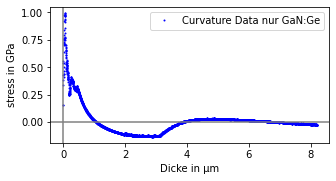

In [26]:
#berechnen stress über dicke:
# def Stress_aus_curvature(k, k_0, d_sub, d_film, M_sub):
#     #aus Quelle: A. Krost_2003_GaN-based epitaxy on silicon; stress measurements
#     return ((k-k_0) *(d_sub**2) *M_sub ) / (6 * d_film)
#def Stress_aus_curvature_ohne_relaxation(k, d_sub, d_film, M_sub):
#    #aus Quelle: A. Krost_2003_GaN-based epitaxy on silicon; stress measurements
#    return (k *(d_sub**2) *M_sub ) / (6 * d_film)
M_sub = 430.14 #GPa für Saphir
d_sub = 0.4479 #mm für Saphir

#stress= []
stress_ohne_relaxation= []
for i in range(len(x_in_muem_nach_GaN_start_wichtiger_Bereich)):
    #stress.append( Stress_aus_curvature( y_curvature_in_km_wichtiger_Bereich[i]*10**-3, y_curvature_in_km_wichtiger_Bereich[0]*10**-3, d_sub*10**-3,x_in_muem_nach_GaN_start_wichtiger_Bereich[i]*10**-6, M_sub))
    stress_ohne_relaxation.append( Stress_aus_curvature_ohne_relaxation( y_curvature_in_km_wichtiger_Bereich[i]*10**-3, d_sub*10**-3,x_in_muem_nach_GaN_start_wichtiger_Bereich[i]*10**-6, M_sub))
    
fig = plt.figure(figsize=(5,2.5))    
#lt.plot(x_in_muem_nach_GaN_start_wichtiger_Bereich, stress, 'o',color='r', markersize=1, label="GaN:Ge mit angenommener ralaxion")
plt.plot(x_in_muem_nach_GaN_start_wichtiger_Bereich, stress_ohne_relaxation, 'o',color='b', markersize=1, label="Curvature Data nur GaN:Ge")
#plt.ylim (0, 1)
#plt.xlim (-4, 8)
plt.axvline(x=0, ymin=0, ymax=1, color='gray')
plt.axhline(y=0, xmin=0, xmax=1, color='gray')
plt.ylabel('stress in GPa')
plt.xlabel('Dicke in \u03bcm')
plt.legend()
plt.savefig('Bilder_V2/stress_aus_Curvature_Daten_Probenwachstum_nach_Dicke_GaN', bbox_inches = "tight")
plt.show()

#print("berechnung unter Annahme kompleter relaxion während wachstum der Probe, wobei k_0 die curvature ist am anfang des schichtwachstums --> daher am anfang =0")

# Vgl In Situ und Raman Stress

In [27]:
# laden der Frequenzen der MEPA und A-Plane aus txt die in jeweiligen anderen Programmen erstellt wurden zur datenübertragung
datei = open('stress_data_GaN.txt','r')
#print(datei.read())
GaN_Stress=[]
for zeile in datei:
	GaN_Stress.append(float(zeile))
datei.close()

datei = open('stress_data_GaN_Positionen.txt','r')
#print(datei.read())
GaN_Stress_Positionen=[]
for zeile in datei:
	GaN_Stress_Positionen.append(float(zeile))
datei.close()

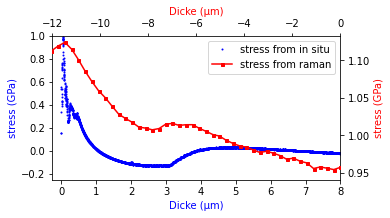

In [28]:

rect = 0.1, 0.1, 0.8, 0.8

fig = plt.figure(figsize=(5,2.5))

ax1 = fig.add_axes(rect)

#ax1.plot(x_in_muem_nach_GaN_start_wichtiger_Bereich, stress, 'o',color='b', markersize=1, label="stress from in situ")
ax1.plot(x_in_muem_nach_GaN_start_wichtiger_Bereich, stress_ohne_relaxation, 'o',color='b', markersize=1, label="stress from in situ")
ax1.set_xlabel('Dicke (\u03bcm)', color='b')
ax1.set_ylabel('stress (GPa)', color='b')
ax1.set_xlim([-0.25, 8])
ax1.set_ylim([-0.25, 1])
#ax1.legend()
#plt.gcf().subplots_adjust(bottom=0.5)

ax2 = fig.add_axes(rect, frameon=False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top')
#plt.tight_layout()
ax2.plot(GaN_Stress_Positionen,GaN_Stress, '-s',color='r', markersize=3, label="stress from raman") # against 2nd x, 2nd y

ax2.set_xlabel('Dicke (\u03bcm)', color='r')
ax2.set_ylabel('stress (GPa)', color='r')
ax2.set_xlim([-12, 0])
#ax2.set_ylim([0.9, 1.15])
#ax2.legend()
fig.legend(bbox_to_anchor=(0.9, 0.9, 0, 0))
#plt.tight_layout()
plt.savefig('Bilder_V2/stress_GaN_Vgl_Raman_InSitu', bbox_inches = "tight")
plt.show()

# thermische Fehlanpassung

an vorher besprochenen Zeitpunkten

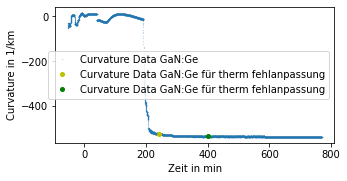

Zeitpunkt in min: 243.00863341666664  Curvature:  -523.813626
Zeitpunkt in min: 402.77639575  Curvature:  -535.533617


In [29]:
fig = plt.figure(figsize=(5,2.5))
plt.plot(x_in_min, y_curvature_in_km, 'o',markersize=0.1, label="Curvature Data GaN:Ge")#, markevery=10
plt.plot(x_in_min[7400], y_curvature_in_km[7400], 'o', color='y',markersize=4, label="Curvature Data GaN:Ge für therm fehlanpassung")#, markevery=10
plt.plot(x_in_min[11400], y_curvature_in_km[11400], 'o', color='g',markersize=4, label="Curvature Data GaN:Ge für therm fehlanpassung")#, markevery=10

#plt.axvline(x=245, ymin=0, ymax=1, color='gray')
#plt.axvline(x=124, ymin=0, ymax=1, color='gray')
#plt.axvline(x=90, ymin=0, ymax=1, color='gray')#x=58
#plt.axvline(x=52.43, ymin=0, ymax=1, color='gray')
#plt.text(x=95,y=3,s='GaN')
#plt.text(x=170,y=3,s='GaN:Ge')
#plt.ylim (0, 100)
#plt.xlim (0, 250)
plt.ylabel('Curvature in 1/km')
plt.xlabel('Zeit in min')
plt.legend()
#plt.savefig('Bilder/Curvature_Daten_Probenwachstum', bbox_inches = "tight")
plt.show()

print("Zeitpunkt in min:", x_in_min[7400]," Curvature: ",y_curvature_in_km[7400])
print("Zeitpunkt in min:",x_in_min[11400]," Curvature: ",y_curvature_in_km[11400])

In [30]:
print("Maximale dicke der angeschätzten relevanten Daten:",max_dicke,"\u03bcm")

Maximale dicke der angeschätzten relevanten Daten: 8.2 μm


In [31]:
print("Stress bei relevanten Zeitpunkten:")
Stress_therm_Fehlanpassung_1=Stress_aus_curvature_ohne_relaxation( y_curvature_in_km[7400]*10**-3, d_sub*10**-3,max_dicke*10**-6, M_sub)
Stress_therm_Fehlanpassung_2=Stress_aus_curvature_ohne_relaxation( y_curvature_in_km[11400]*10**-3, d_sub*10**-3,max_dicke*10**-6, M_sub)
print("Zeitpunkt:", x_in_min[7400]," Curvature: ",y_curvature_in_km[7400],"Stress:",Stress_therm_Fehlanpassung_1)
print("Zeitpunkt:", x_in_min[11400]," Curvature: ",y_curvature_in_km[11400],"Stress:",Stress_therm_Fehlanpassung_2)


Stress bei relevanten Zeitpunkten:
Zeitpunkt: 243.00863341666664  Curvature:  -523.813626 Stress: -0.9187210019612395
Zeitpunkt: 402.77639575  Curvature:  -535.533617 Stress: -0.93927679001265


# Einbauen der Thermischen Fehlanpassung

In [32]:
#verschieben der y werte um - thermischer fehlanpessung
#dafür mittlwert bei beiden betrachteten Punkten bilden

In [33]:
therm_Fehlanpassung= (Stress_therm_Fehlanpassung_1 + Stress_therm_Fehlanpassung_2)/2
print(therm_Fehlanpassung)

-0.9289988959869447


In [34]:
for i in range(len(stress_ohne_relaxation)):
    stress_ohne_relaxation[i]=stress_ohne_relaxation[i]-therm_Fehlanpassung

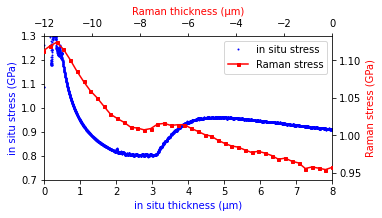

In [37]:

rect = 0.1, 0.1, 0.8, 0.8

fig = plt.figure(figsize=(5,2.5))

ax1 = fig.add_axes(rect)

#ax1.plot(x_in_muem_nach_GaN_start_wichtiger_Bereich, stress, 'o',color='b', markersize=1, label="stress from in situ")
ax1.plot(x_in_muem_nach_GaN_start_wichtiger_Bereich, stress_ohne_relaxation, 'o',color='b', markersize=1, label="in situ stress")
ax1.set_xlabel('in situ thickness (\u03bcm)', color='b')
ax1.set_ylabel('in situ stress (GPa)', color='b')
ax1.set_xlim([0, 8])
ax1.set_ylim([0.7, 1.3])
#ax1.legend()
#plt.gcf().subplots_adjust(bottom=0.5)

ax2 = fig.add_axes(rect, frameon=False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top')
#plt.tight_layout()
ax2.plot(GaN_Stress_Positionen,GaN_Stress, '-s',color='r', markersize=3, label="Raman stress") # against 2nd x, 2nd y

ax2.set_xlabel('Raman thickness (\u03bcm)', color='r')
ax2.set_ylabel('Raman stress (GPa)', color='r')
ax2.set_xlim([-12, 0])
#ax2.set_ylim([0.9, 1.15])
#ax2.legend()
fig.legend(bbox_to_anchor=(0.9, 0.9, 0, 0))
#plt.tight_layout()
plt.savefig('Bilder_V2/stress_GaN_Vgl_Raman_InSitu_mit_Therm_Fehlanpassung', bbox_inches = "tight")
plt.show()

In [36]:
#blau: dicke von Null (keine GaN) bis zur entsprechenden gewachssenden schichtdicke
#rot: Null an Proben Oberfläche, negative werte sind Distanz von Oberfläche bis zu fokuspunkt